#  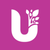   **Universidad de la ciudad de Buenos Aires**

---

# Proyecto integrador — 5HP
**Título:** Predicción de precio de propiedades en Argentina  
**Equipo 5HP:** 
- MATIAS ALEJANDRO BANCHIO  
- PABLO GABRIEL CIOCIANO  
- PAULA GISELA COCHIMANO  
- ANTONIO LUIS EMILIO MARTINEZ  
- ENRIQUE IGNACIO VAZQUEZ

**Curso:** (Programación Avanzada para Ciencia de Datos)  
**Fecha:** (Noviembre 2025)


## Resumen ejecutivo
En este proyecto, se analiza un dataset de propiedades en Argentina con el objetivo de desarrollar un modelo predictivo del precio de inmuebles en función de sus características (ubicación, tipo de propiedad, cantidad de ambientes, superficie, etc.).

El proyecto aplica conceptos de análisis exploratorio de datos (EDA), preprocesamiento, y modelado predictivo mediante algoritmos de regresión y machine learning (como Linear Regression, Random Forest o XGBoost).

**Objetivo:** Construir un modelo predictivo que estime el precio (USD) de propiedades en Argentina usando datos públicos del dataset provisto.

**Resultados esperados:** pipeline reproducible que incluye: limpieza, EDA, features, entrenamiento de modelos (Regresión Lineal, Random Forest y XGBoost), evaluación con MAE/RMSE/R² y análisis de importancia de features.


## Planificación del proyecto
1. Recolección y preparación de datos  
2. Análisis exploratorio (EDA)  
3. Ingeniería de features y limpieza avanzada  
4. Modelado (varias técnicas)  
5. Evaluación y selección de modelo final  
6. Documentación y presentación

**Recursos:** Google Colab, Python (pandas, scikit-learn, xgboost), GitHub (repositorio)


## Reproducibilidad y entorno
Indicar cómo reproducir el trabajo en Colab: dependencias y cómo ejecutar el notebook.


## Importación de Librerías

In [3]:
import pandas as pd
import numpy as np
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

## 1. Carga y Limpieza de Datos 🧹

In [5]:
# Cargar el dataset original
csv_path = "data/entrenamiento.csv" 
df_raw = pd.read_csv(csv_path)

print(f"Shape original del dataset: {df_raw.shape}")

# 1. Filtrar solo operaciones de 'Venta' y moneda 'USD'
df = df_raw[(df_raw['operation_type'] == 'Venta') & (df_raw['currency'] == 'USD')].copy()

# 2. Seleccionar columnas relevantes y eliminar nulos en base a ellas
# Se añade 'bathrooms' y se corrige 'l1' por 'l2'
cols_to_keep = ['price', 'surface_covered', 'rooms', 'bathrooms', 'property_type', 'l2']
df = df[cols_to_keep].dropna()

# 3. Filtrar outliers de precio para un modelo más robusto
price_min, price_max = 10000, 1000000
df = df[(df['price'] > price_min) & (df['price'] < price_max)]
df['rooms'] = df['rooms'].astype(int)
df['bathrooms'] = df['bathrooms'].astype(int)

# 4. Renombrar columnas para mayor claridad
df.columns = ['price', 'surface', 'rooms', 'bathrooms', 'property_type', 'city']

# Guardar el dataset limpio para reproducibilidad
df.to_csv('data/cleaned_data.csv', index=False)

print(f"Shape del dataset limpio y procesado: {df.shape}")
df.head()

Shape original del dataset: (992192, 25)
Shape del dataset limpio y procesado: (200091, 6)


,price,surface,rooms,bathrooms,property_type,city
1,235500.0,67.0,3,2,Departamento,Capital Federal
2,175000.0,55.0,2,1,Departamento,Capital Federal
3,140000.0,47.0,2,1,PH,Capital Federal
4,173000.0,64.0,3,1,Departamento,Capital Federal
5,155000.0,55.0,3,1,PH,Capital Federal


## 2. Análisis Exploratorio de Datos (EDA) 📊

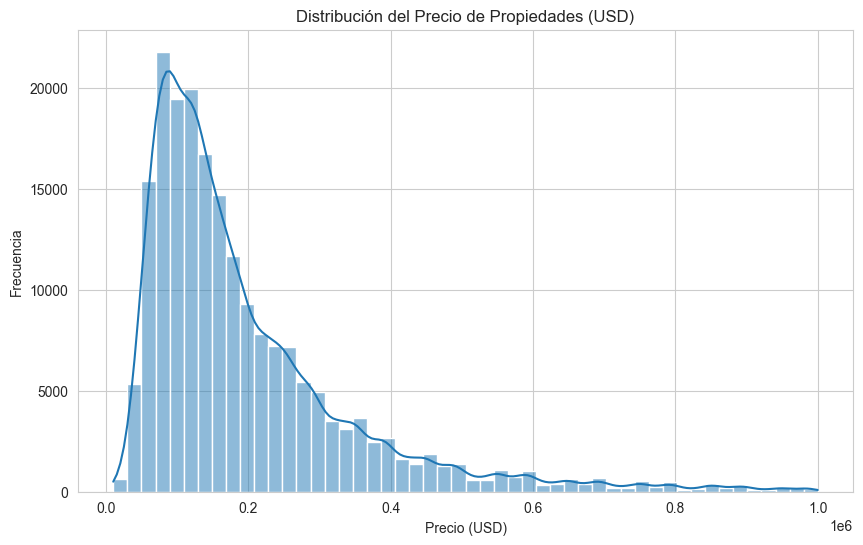

In [6]:
# Distribución de la variable objetivo (Precio)
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True, bins=50)
plt.title('Distribución del Precio de Propiedades (USD)')
plt.xlabel('Precio (USD)')
plt.ylabel('Frecuencia')
plt.show()

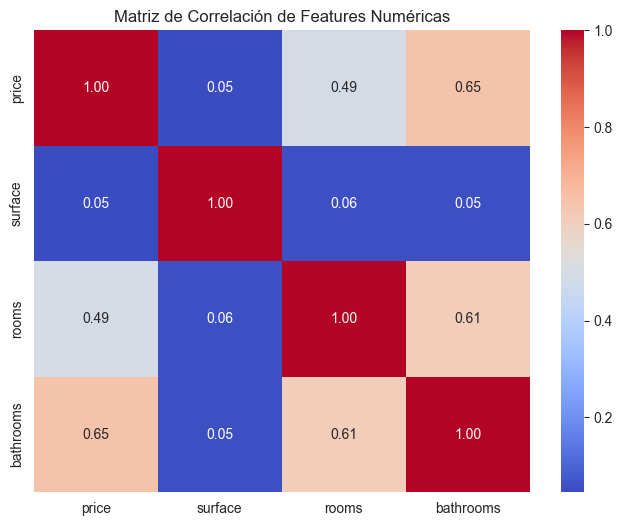

In [7]:
# Matriz de correlación para variables numéricas
plt.figure(figsize=(8, 6))
corr_matrix = df[['price', 'surface', 'rooms', 'bathrooms']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación de Features Numéricas')
plt.show()

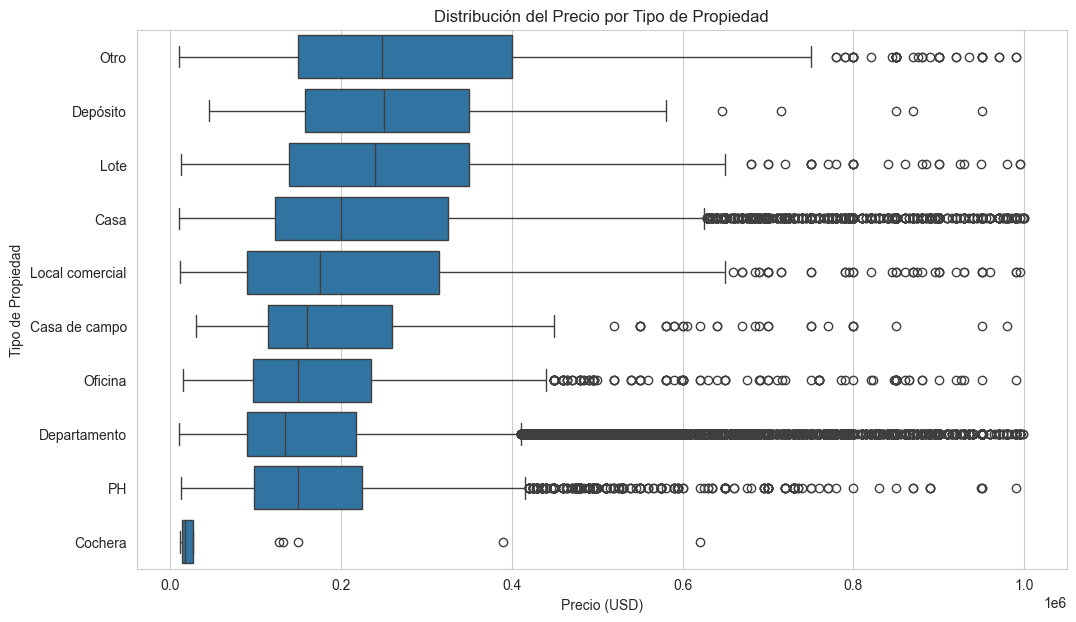

In [8]:
# Precio promedio por tipo de propiedad
plt.figure(figsize=(12, 7))
order = df.groupby('property_type')['price'].mean().sort_values(ascending=False).index
sns.boxplot(data=df, x='price', y='property_type', order=order)
plt.title('Distribución del Precio por Tipo de Propiedad')
plt.xlabel('Precio (USD)')
plt.ylabel('Tipo de Propiedad')
plt.show()

## 3. Ingeniería de Features y División de Datos 🔪

In [10]:
# Definir variables predictoras (X) y objetivo (y)
X = df[['surface', 'rooms', 'bathrooms', 'property_type', 'city']]
y = df['price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Tamaño del set de entrenamiento: {X_train.shape}")
print(f"Tamaño del set de prueba: {X_test.shape}")

Tamaño del set de entrenamiento: (160072, 5)
Tamaño del set de prueba: (40019, 5)


## 4. Creación del Pipeline y Entrenamiento de Modelos Base 🤖

In [11]:
# Definir las columnas numéricas y categóricas
numeric_features = ['surface', 'rooms', 'bathrooms']
categorical_features = ['property_type', 'city']

# Crear el transformador de columnas para el preprocesamiento
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Definir los modelos a comparar (incluyendo XGBoost)
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

results = []

# Entrenar y evaluar cada modelo
for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    results.append({
        'Modelo': name,
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
print("Resultados de los modelos base:")
results_df

KeyboardInterrupt: 

## 5. Ajuste de Hiperparámetros (Hyperparameter Tuning) 🛠️

In [ ]:
# Se elige RandomForest por su buen balance entre rendimiento y velocidad
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20],
    'model__min_samples_leaf': [1, 5]
}

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

print("Iniciando ajuste de hiperparámetros para RandomForest...")
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("\nMejores hiperparámetros encontrados:", grid_search.best_params_)

## 6. Evaluación del Modelo Final y Análisis de Resultados 📈

In [ ]:
# Evaluar el modelo optimizado
y_pred_best = best_model.predict(X_test)

tuned_results = {
    'Modelo': 'RandomForest (Tuned)',
    'MAE': mean_absolute_error(y_test, y_pred_best),
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_best)),
    'R2': r2_score(y_test, y_pred_best)
}

results_df = pd.concat([results_df, pd.DataFrame([tuned_results])], ignore_index=True)

print("Comparativa final de modelos:")
results_df

In [ ]:
# Gráfico comparativo de RMSE
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Modelo', y='RMSE', palette='viridis')
plt.title('Comparación de RMSE entre Modelos')
plt.xticks(rotation=15)
plt.show()

# Gráfico comparativo de R²
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Modelo', y='R2', palette='plasma')
plt.title('Comparación de R² entre Modelos')
plt.ylim(0, 1) # R2 va de 0 a 1
plt.xticks(rotation=15)
plt.show()

In [ ]:
# Visualización de Valores Reales vs. Predichos
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_best, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2)
plt.xlabel('Precio Real (USD)')
plt.ylabel('Precio Predicho (USD)')
plt.title('Precio Real vs. Predicho (Mejor Modelo)')
plt.show()

In [ ]:
# Análisis de Importancia de Features
importances = best_model.named_steps['model'].feature_importances_
cat_features = best_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
feature_names = numeric_features + list(cat_features)

importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df.head(20), x='importance', y='feature')
plt.title('Top 20 Features más importantes')
plt.show()

## 7. Persistencia del Modelo y Resultados 💾

In [ ]:
# Guardar el mejor modelo entrenado
joblib.dump(best_model, 'data/best_model.pkl')
print("Modelo final guardado como 'data/best_model.pkl'")

# Guardar resultados en una base de datos DuckDB
try:
    conn = duckdb.connect('data/properati_models.db')
    
    # Preparar el dataframe de configuración
    config_df = pd.DataFrame([grid_search.best_params_])
    
    # Datos de entrada limpios
    conn.execute("CREATE OR REPLACE TABLE input_data AS SELECT * FROM df")
    
    # Resultados de los modelos
    conn.execute("CREATE OR REPLACE TABLE model_results AS SELECT * FROM results_df")
    
    # Configuración del mejor modelo
    conn.execute("CREATE OR REPLACE TABLE model_config AS SELECT * FROM config_df")
    
    conn.close()
    print("Datos, resultados y configuración guardados en 'data/properati_models.db' (usando DuckDB)")
except Exception as e:
    print(f"Error al guardar en la base de datos DuckDB: {e}")

print("\n¡Pipeline completo ejecutado correctamente!")